In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix


In [5]:
unet_dir = '/home/ahoag/ML/mars/unet'
img_save_dir = os.path.join(unet_dir,'images_for_cnn')
mask_save_dir = os.path.join(unet_dir,'masks')
annotation_file = os.path.join(unet_dir,"annotations_800x600_2021Apr30.csv")
df = pd.read_csv(annotation_file)
df

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,ESP_011261_1960.jpg,712346,"{""caption"":"""",""public_domain"":""no"",""image_url""...",1,0,"{""name"":""circle"",""cx"":128,""cy"":494,""r"":38.013}","{""name"":""not_defined"",""type"":""unknown"",""image_..."
1,ESP_011277_1825.jpg,542472,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}
2,ESP_011287_2165.jpg,609278,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}
3,ESP_011289_1950.jpg,503972,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}
4,ESP_011290_1800.jpg,579742,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}
...,...,...,...,...,...,...,...
2060,PSP_010877_1610.jpg,481840,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}
2061,PSP_010882_2040.jpg,668592,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}
2062,PSP_010888_1510.jpg,494850,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}
2063,PSP_010888_2030.jpg,586660,"{""caption"":"""",""public_domain"":""no"",""image_url""...",0,0,{},{}


In [ ]:
# First get rid of files that I marked as "is_deimos" in the file attribute. These aren't just deimos but
# are bad for one reason or another 

In [ ]:
def parse(x):
    file_attr = eval(x)
    is_deimos = file_attr['is_deimos']
    if is_deimos == 'yes':
        return 1
    else:
        return 0

In [ ]:
df['is_deimos'] = df.file_attributes.apply(parse)

In [ ]:
df_good = df.loc[df['is_deimos']==0,:]
df_good

In [ ]:
# Now make a df from just files where I marked craters
df_craters = df_good.loc[df_good['region_shape_attributes'] != '{}',:]
df_craters

In [4]:
# OK so we are left with 270 craters.
# If a file has multiple annotations they are saved as separate rows. So when we loop through the list we need to 
# check to make sure we grab all annotations and add them to the seg mask. 
# Now we loop through those and make corresponding masks and save them out
img_dir = '/home/ahoag/ML/mars/downloaded_images_800x600'

processed_filenames = []
for ii,row in df_craters.iterrows():
    filename = row['filename']
#     if filename != "PSP_010667_1920.jpg":
#         continue
    print(filename)
    if filename in processed_filenames:
        print("Filename already processed")
        print()
        continue
    print("Filename not already processed")
    full_filename = os.path.join(img_dir,filename)
    # Copy over images to their own directory
    savename_img = os.path.join(img_save_dir,filename)
    shutil.copyfile(full_filename,savename_img)
    # initialize segmask
    seg = np.zeros((600,800),dtype='uint8')
    nrows, ncols = seg.shape
    row, col = np.ogrid[:nrows, :ncols]
    # find all annotations for this filename and add them to the segmask
    df_this_filename = df_craters.loc[df_craters['filename']==filename,:]
    shp_dicts_this_filename = [eval(x) for x in df_this_filename['region_shape_attributes']]
    for shp_dict in shp_dicts_this_filename:
        disk_mask = ((row - shp_dict['cy'])**2 + (col - shp_dict['cx'])**2 <
                            (shp_dict['r'])**2)
        seg[disk_mask] = 1
    mask_im = Image.fromarray(seg)
    savename = os.path.join(mask_save_dir,filename.replace('.jpg','_mask.png'))
    mask_im.save(savename)
    mask_im.close()
    processed_filenames.append(filename)
    print("Saved mask")
    print()

NameError: name 'df_craters' is not defined

In [ ]:
im_recov = Image.open(os.path.join(mask_save_dir,"ESP_011765_1780_mask.png"))
plt.imshow(im_recov)

In [ ]:
# There should be two craters in this mask

# Make keras datasets

In [12]:
input_dir = img_save_dir
target_dir = mask_save_dir
img_size = (160, 160)
num_classes = 2
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 183
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_011261_1960.jpg | /home/ahoag/ML/mars/unet/masks/ESP_011261_1960_mask.png
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_011386_2065.jpg | /home/ahoag/ML/mars/unet/masks/ESP_011386_2065_mask.png
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_011677_1655.jpg | /home/ahoag/ML/mars/unet/masks/ESP_011677_1655_mask.png
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_011732_1595.jpg | /home/ahoag/ML/mars/unet/masks/ESP_011732_1595_mask.png
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_011765_1780.jpg | /home/ahoag/ML/mars/unet/masks/ESP_011765_1780_mask.png
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_011834_1605.jpg | /home/ahoag/ML/mars/unet/masks/ESP_011834_1605_mask.png
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_011898_2175.jpg | /home/ahoag/ML/mars/unet/masks/ESP_011898_2175_mask.png
/home/ahoag/ML/mars/unet/images_for_cnn/ESP_012425_1455.jpg | /home/ahoag/ML/mars/unet/masks/ESP_012425_1455_mask.png
/home/ahoag/ML/mars/unet/images_f

## Load and vectorize batches of data

In [13]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
#             # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
#             y[j] -= 1
        return x, y

In [39]:
# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [40]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = data_augmentation(inputs)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         sequential[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
______________________________________________________________________________________________

In [15]:
import random

# Split our img paths into a training and a validation set
val_samples = 20 # out of 183 files so basically 30%
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [31]:
# verify it worked - should be 133 in training set, 50 in validation set
print(len(train_gen.input_img_paths))
print(len(val_gen.input_img_paths))

163
20


In [41]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )
model.compile(optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy")

# callbacks = [
#     keras.callbacks.ModelCheckpoint("../unet/model_outputs/segmentation.h5", save_best_only=True)
# ]
callbacks = [
    keras.callbacks.ModelCheckpoint("../unet/model_outputs/save_at_{epoch}_lr1e-4_augment.h5"),
]

# Train the model, doing validation at the end of each epoch.
epochs = 25
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
10/10 [==============================] - 9s 766ms/step - loss: 0.8783 - val_loss: 5.9625
Epoch 2/25
10/10 [==============================] - 7s 706ms/step - loss: 0.5630 - val_loss: 3.6782
Epoch 3/25
10/10 [==============================] - 7s 700ms/step - loss: 0.3802 - val_loss: 1.7262
Epoch 4/25
10/10 [==============================] - 7s 697ms/step - loss: 0.3401 - val_loss: 0.9341
Epoch 5/25
10/10 [==============================] - 7s 690ms/step - loss: 0.3345 - val_loss: 0.6874
Epoch 6/25
10/10 [==============================] - 7s 689ms/step - loss: 0.2860 - val_loss: 0.5339
Epoch 7/25
10/10 [==============================] - 7s 711ms/step - loss: 0.2872 - val_loss: 0.4272
Epoch 8/25
10/10 [==============================] - 7s 695ms/step - loss: 0.2755 - val_loss: 0.3958
Epoch 9/25
10/10 [==============================] - 7s 688ms/step - loss: 0.3053 - val_loss: 0.3841
Epoch 10/25
10/10 [==============================] - 7s 691ms/step - loss: 0.2750 - val_loss: 0.3949

## Look at training curves

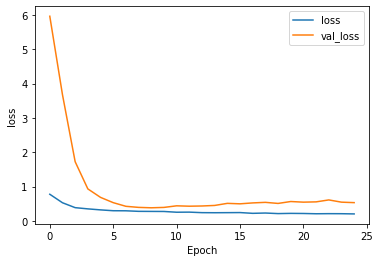

In [77]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

## Visualize predictions

In [43]:
min_val_loss = np.min(history.history['val_loss'])
mindex = history.history['val_loss'].index(min_val_loss)+1
min_val_loss

0.38409683108329773

In [44]:
save_file = f'../unet/model_outputs/save_at_{mindex}_lr1e-4_augment.h5' 
best_model = keras.models.load_model(save_file)

In [45]:
# Generate predictions for all images in the validation set

# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = best_model.predict(val_gen)
# train_preds = best_model.predict(train_gen)

In [63]:
im_input = Image.open(filename)
im_input.size

(800, 600)

In [67]:
im_thumb = im_input.resize((160,160))
im_thumb.size

(160, 160)

In [66]:
im_input.size

(800, 600)

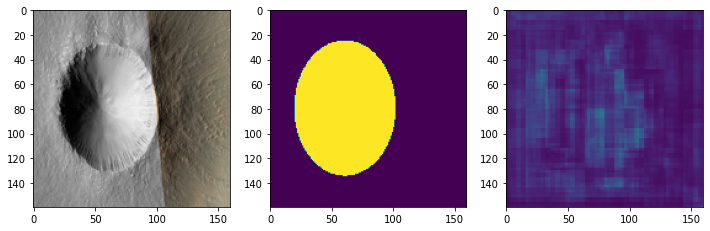

In [73]:
# Display results for validation image #10
i = 4

fig = plt.figure(figsize=(12,8))
# Display input image
ax_input = fig.add_subplot(131)
filename=val_input_img_paths[i]
im_input = Image.open(filename)
ax_input.imshow(im_input.resize((160,160)))
# Display ground-truth target mask
ax_ground_truth = fig.add_subplot(1,3,2)
filename_ground_truth = val_target_img_paths[i]
im_ground_truth = Image.open(filename_ground_truth)
ax_ground_truth.imshow(im_ground_truth.resize((160,160)))
# # Display mask predicted by our model
ax_pred = fig.add_subplot(1,3,3)
mask = np.squeeze(val_preds[i])
ax_pred.imshow(mask,vmin=0,vmax=1)

IT looks like it is doing somethig but not very well. Maybe I am using the wrong loss function... Or maybe I just need to use the boundaries of the craters as input and not the entire crater? Or maybe I need a bigger training set! It is very small as is. Check out: https://github.com/zhixuhao/unet

## Trying different Unet
From: https://github.com/zhixuhao/unet, https://towardsdatascience.com/medical-images-segmentation-using-keras-7dc3be5a8524

In [ ]:
# import skimage.io as io
# import skimage.transform as trans
# import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model



In [ ]:
# Hmm looks like it didn't work. Taking a closer look at the validation predictions 
# I noticed that they all kind of look the same. They have this strange pattern in the top left of the image. 
# Something went wrong probably in how I am choosing my dimensions/classes in the model

# Saving the model
The fact that `callbacks` was using during model.fit allowed the model to save out an h5 file after each epoch:
```python
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
```
In test_load_cnn() I showed that I can successfully load the model with:
```python
keras.models.load_model('save_at_40.h5')
```

## Run more epochs
I want to run more epochs leaving off from epoch 40, the last epoch that I ran:

In [ ]:
epochs = 10

history2 = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

It does look like it picked up from where it left off! I can tell by the accuracy of the model being much closer to when it left off (\~0.8) compared to when I started (\~0.5).

In [ ]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Leveling off now. Pretty happy with 80% accuracy on validation set! Is there a way to combine this history with the previous? Yes, turns out history.history is just a dictionary:

In [ ]:
history.history.keys()

In [ ]:
all_history = {}
for key in history.history:
    all_history[key] = history.history[key]
    all_history[key].extend(history2.history[key])

In [ ]:
plt.plot(all_history['accuracy'], label='accuracy')
plt.plot(all_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# It looks like it might still be improving. Try to run for 10 more epochs
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_round3.h5"),
]
history3 = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

In [ ]:
history3=history2

In [ ]:
# View entire history of 60 epochs from 3 runs
# all_history = {}
for key in history.history:
    all_history[key].extend(history3.history[key])
    

In [ ]:
plt.plot(all_history['accuracy'], label='accuracy')
plt.plot(all_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
plt.plot(all_history['accuracy'], label='train_accuracy')
plt.plot(all_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()
plt.savefig('../attempt1/training_attempt1.png')

OK looks like it is overfitting now. Validation accuracy peaked around epoch 52 or 53. Can find the exact peak. 

In [ ]:
max_val_acc = max(all_history['val_accuracy'])
all_history['val_accuracy'].index(max_val_acc)+1 

In [ ]:
print(f"Maximum val_accuracy = {max_val_acc}")

## Evaluate model (at epoch 53) on test set

In [ ]:
save_file = '../attempt1/cnn_saved_epochs/save_at_53.h5'
best_model = keras.models.load_model(save_file)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_fld,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)


In [ ]:
# Take a look at some of these to make sure they were loaded in right
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        print(f"i={i},label={labels[i]}")
        ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Load in test images and labels
result = best_model.evaluate(test_ds)

Looks like my test-set accuracy is ~80%. Pretty good. Let's look at confusion matrix

In [ ]:
test_predictions = []
test_labels = []
test_probs = []
for x, y in test_ds:
    new_predictions = best_model.predict(x)[:,0]
    test_predictions.extend(list(map(round,new_predictions)))
    test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        test_probs.append(pred_float)
    

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = 'd'
    fmt_norm = '.2f'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt)+f' ({format(cm_norm[i, j], fmt_norm)})',
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [ ]:
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, classes = ['No craters', 'Craters'],
                      title = '',)
plt.tight_layout()
plt.savefig('../attempt1/confusion_matrix_attempt1.png')

So the model is pretty balanced in terms of precision and recall.

In [ ]:
false_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_negatives.append(fn_dict)


In [ ]:
# inspect false negatives
np.random.shuffle(false_negatives)
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
    plt.imshow(false_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = false_negatives[i]['pred']
    plt.title(f"p={pred_float:.2f}",fontsize=12)
    plt.text(0,0.85,chr(65+i),transform=ax.transAxes,color='r',fontsize='xx-large')
    plt.axis("off")
plt.savefig('../attempt1/false_negatives_attempt1.png')

In [ ]:
false_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_positives.append(fn_dict)

In [ ]:
# inspect false positives
plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
    plt.imshow(false_positives[i]['image'].numpy().astype("uint8"))
    pred_float = false_positives[i]['pred']
    plt.title(f"p={pred_float:.2f}",fontsize=12)
    plt.axis("off")
    plt.text(0,0.85,chr(65+i),transform=ax.transAxes,color='r',fontsize='xx-large')

savename = "../attempt1/false_positives_attempt1.png"
plt.savefig(savename)

In [ ]:
true_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_positives.append(fn_dict)

In [ ]:
# inspect True positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_positives[i]['image'].numpy().astype("uint8"))
    pred_float = true_positives[i]['pred']
    plt.title(f"True Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

It definitely does seem like the more obvious craters are detected. One thing I am noticing is that in the true positives the backgrounds are much more uniform. In the false negatives (fail to detect a crater that is there) the backgrounds are much more colorful. 

In [ ]:
all_probabilities = [] 

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        all_probabilities.append(pred_float)

In [ ]:
# Plot distribution of actual probabilities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_probabilities)
ax.set_xlabel('Probability of crater in image')
ax.set_ylabel('N')

## ROC - AUC curve

In [ ]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """
    Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve.
    ---INPUT---
    predictions:    predicted classes in the test set
    
    """
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model (test set)')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [ ]:
train_predictions = []
train_labels = []
train_probs = []
for x, y in train_ds:
    new_predictions = best_model.predict(x)[:,0]
    train_predictions.extend(list(map(round,new_predictions)))
    train_labels.extend(list(map(round,y.numpy())))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        train_probs.append(pred_float)
    


In [ ]:
evaluate_model(test_predictions,test_probs,train_predictions, train_probs)

This is about what I got for the titanic survival challenge which isn't bad!

Let's look at some false positives.

These have a similar background color to the true positives, so it might be using background color here. Another reason to use grayscale instead of color images. 

In [ ]:
true_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_negatives.append(fn_dict)

In [ ]:
# inspect true negative
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = true_negatives[i]['pred']
    plt.title(f"True negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

In [ ]:
# Save best model
best_model.save('../cnn_saved_epochs/best_model_epoch53.h5')

## Things to do
- Run the model on the rest of the dataset.
- A bigger training/validation set. It's pretty amazing it is doing as well as it is given the limited size of the training set I used.
- Try using grayscale images instead of color. Color might be throwing off the model. 
- Figure out how to do cross validation with this kind of model
- Keras tuner
- Try different CNN architectures
- Try use_multiprocessing=True in model.fit() to see if we get improvement
- Try different image sizes to see if that helps/hurts training
- Purify training/val set to only include obvious craters
- Learn how to look at the intermediate filters in my model

## Done
- Make a test set and evaluate the model on that -- Take a look at confusion matrix/ ROC-AUC curve
